# Finite state machine with random transition rules - Pytorch transformer

In this notebook, we replicate the model explored in ``FiniteStateMachine_random.ipynb`` using an optimized version of the Transformer architecture (see https://pytorch.org/docs/stable/_modules/torch/nn/modules/transformer.html#Transformer). Moreover, we will try to reproduce the results using only the Decoder portion of the Transformer (https://pytorch.org/docs/stable/generated/nn.TransformerDecoder.html)

**OBS**: to benchmark this new model, we will use the transition rules corresponding to version 2.4 (highest entropy). However, we will change the data format.

**Benchmark**: the new model has the same performance than the old one, but with the proper architecture it requires way less epochs to achieve the same performance - DONE

With only 2 epochs, the model is already able to predict the next token with a high degree of accuracy.

Results:
- Last token accuracy on training set: 0.71. To be compared with 0.71
- Last token accuracy on validation set: 0.71. To be compared with 0.70
- Last token accuracy on test set: 0.70. To be compared with 0.71

**New test**: another set of transition rules, in a larger token space - DONE (performance was optimal)


**Experiments**: using a fixed architecture (see parameters below), train a model with 6 different transition rules. Repeat the whole process twice (using a different random seed).
- Version 1: 8 tokens, sequences of lenght 32. Initial dataset size: 40000. (train: 28000, validation: 8000, test: 4000). For assessing the test performance, generate 5 test datasets - DONE!
- Version 2: 16 tokens, sequences of lenght 64. Initial dataset size: 40000. (train: 28000, validation: 8000, test: 4000). For assessing the test performance, generate 5 test datasets - DONE!

**Follow-up experiments**: if any of the versions has a sub-optimal performance, focus on one case (i.e., a single dataset with a definite transition matrix) to explore the complexity of the architecture.


**To do list**:

- Figure out a good explanation about why the validation loss is larger than the training loss
- Plots: add the ideal scores. Use the transition matrix to get those (weighted average of the maximum prob for each row)
- New dataset - harder tasks


In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import torch.nn as nn
import torch
from torch.utils.data import DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence
from torch.cuda.amp import GradScaler, autocast
import random
import math
import pickle
from functools import partial
from time import time
from Autobots_v2 import AutobotConfig, Autobot

%matplotlib inline
%config InlineBackend.figure_format='retina'

import warnings
warnings.filterwarnings("ignore")

In [19]:
##################### GLOBAL PARAMETERS ########################

VERSION = '2.1'
EXPERIMENT = '6'
SEED = 48898989

if EXPERIMENT == '1':
    BASELINE_PROBABILITY = 0.90  
elif EXPERIMENT == '2':
    BASELINE_PROBABILITY = 0.85  
elif EXPERIMENT == '3':
    BASELINE_PROBABILITY = 0.80  
elif EXPERIMENT == '4':
    BASELINE_PROBABILITY = 0.75  
elif EXPERIMENT == '5':
    BASELINE_PROBABILITY = 0.70  
elif EXPERIMENT == '6':
    BASELINE_PROBABILITY = 0.65
else:
    raise ValueError('Invalid experiment number')

DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

BATCH_SIZE = 32
TRAIN_FRACTION = 0.7
VALIDATION_FRACTION = 0.2
TEST_FRACTION = 0.1

NUM_SEQUENCES = 40000
SEQUENCE_LENGTH = 64
NUM_TOKENS = 16
VOCABULARY = list(range(NUM_TOKENS))

# Architecture
NUMBER_LAYERS = 8
NUMBER_HEADS = 4
D_MODEL = 8
DROPOUT = 0.1
D_FF = 512
ACTIVATION = 'relu'
USE_STANDARD_POSITIONAL_ENCODING = True
TIE_WEIGHTS_OUTPUT = False 
CONTEXT_SIZE = 500
LEARNING_RATE = 0.001
BETA_1 = 0.9
BETA_2 = 0.98
EPS = 10**(-9)



# Set random seed for reproducibility
torch.manual_seed(SEED)


#########################################################

## Data Preparation

In [20]:
GENERATE_DATA = False


def get_transition_matrix(num_tokens, baseline_prob, step=0.01):

    transtition_rules = dict()
    for i in range(num_tokens):
        
        weights = np.random.random(num_tokens - 1)
        fixed_weight = np.random.uniform(baseline_prob, baseline_prob + step)
        
        remaining_sum = 1 - fixed_weight
        weights *= remaining_sum / np.sum(weights)
        
        weights = np.append(weights, fixed_weight)
        np.random.shuffle(weights)
        
        transtition_rules[i] = weights.tolist()

    return transtition_rules


def generate_sequences(vocabulary, sequence_length, num_sequences, transition_rules):

    sequences = []
    
    for _ in range(num_sequences):
        sequence = [random.choice(vocabulary)]
        while len(sequence) <= sequence_length:
            current_token = sequence[-1]
            next_token = random.choices(vocabulary, weights=transition_rules[current_token])[0]
            sequence.append(next_token)
        sequences.append(sequence)
    
    return sequences



def shift_and_append(raw_data, shift_step=1):
    
    out = []
    
    for sample in raw_data:

        X = torch.tensor(sample[:-shift_step])
        y = torch.tensor(sample[shift_step:])

        out.append([X,y])
        
    return out


TRANSITION_RULES = get_transition_matrix(NUM_TOKENS, BASELINE_PROBABILITY)



if GENERATE_DATA:


    raw_sequences = generate_sequences(VOCABULARY, SEQUENCE_LENGTH, NUM_SEQUENCES, TRANSITION_RULES)

    source_target_sequences = shift_and_append(raw_sequences)

    train_data, val_data, test_data = random_split(source_target_sequences, [TRAIN_FRACTION, VALIDATION_FRACTION, TEST_FRACTION])

    torch.save(train_data, f'datasets_v2/train_data_v{VERSION}_experiment_{EXPERIMENT}')
    torch.save(val_data, f'datasets_v2/val_data_v{VERSION}_experiment_{EXPERIMENT}')
    torch.save(test_data, f'datasets_v2/test_data_v{VERSION}_experiment_{EXPERIMENT}')

else:
    train_data = torch.load(f'datasets_v2/train_data_v{VERSION}_experiment_{EXPERIMENT}')
    val_data = torch.load(f'datasets_v2/val_data_v{VERSION}_experiment_{EXPERIMENT}')
    test_data = torch.load(f'datasets_v2/test_data_v{VERSION}_experiment_{EXPERIMENT}')


train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, drop_last=True)
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, drop_last=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, drop_last=True)

print('Number of sequences in training set:', len(train_data))
print('Number of sequences in validation set:', len(val_data))
print('Number of sequences in test set:', len(test_data))

Number of sequences in training set: 28000
Number of sequences in validation set: 8000
Number of sequences in test set: 4000


In [93]:
################# EXAMPLE OF DATA ######################
sample = next(iter(train_dataloader))
X_sample, y_sample = sample
print(f'Shape of X_sample: {X_sample.shape}. Shape of y_sample: {y_sample.shape}')
print(f'Example of memory seuqence: {X_sample[0]}')
print(f'Example of target sequence: {y_sample[0]}')
########################################################

Shape of X_sample: torch.Size([32, 64]). Shape of y_sample: torch.Size([32, 64])
Example of memory seuqence: tensor([ 0,  3,  4,  0, 12, 10, 12, 10, 13, 12, 14, 10, 13, 12, 10, 13, 12, 10,
        13, 12,  8,  5,  1, 11, 11,  3,  4, 14, 13, 12, 11,  3,  4, 14, 13, 12,
         4, 14, 13,  2, 13,  8, 12,  0, 12, 10, 13, 12, 10, 13, 12,  8,  9,  1,
        11,  3,  4,  7,  9,  1,  4, 12, 10, 13])
Example of target sequence: tensor([ 3,  4,  0, 12, 10, 12, 10, 13, 12, 14, 10, 13, 12, 10, 13, 12, 10, 13,
        12,  8,  5,  1, 11, 11,  3,  4, 14, 13, 12, 11,  3,  4, 14, 13, 12,  4,
        14, 13,  2, 13,  8, 12,  0, 12, 10, 13, 12, 10, 13, 12,  8,  9,  1, 11,
         3,  4,  7,  9,  1,  4, 12, 10, 13, 12])


Transition rules for token 0: [0.012, 0.031, 0.018, 0.012, 0.03, 0.044, 0.044, 0.005, 0.024, 0.005, 0.025, 0.042, 0.658, 0.01, 0.031, 0.01]
Transition rules for token 1: [0.035, 0.033, 0.037, 0.014, 0.031, 0.013, 0.024, 0.022, 0.028, 0.012, 0.003, 0.656, 0.014, 0.03, 0.012, 0.036]
Transition rules for token 2: [0.001, 0.041, 0.017, 0.027, 0.037, 0.023, 0.045, 0.037, 0.029, 0.01, 0.018, 0.009, 0.012, 0.66, 0.024, 0.01]
Transition rules for token 3: [0.001, 0.036, 0.005, 0.028, 0.651, 0.027, 0.039, 0.034, 0.014, 0.021, 0.031, 0.03, 0.011, 0.026, 0.024, 0.022]
Transition rules for token 4: [0.038, 0.002, 0.003, 0.012, 0.052, 0.005, 0.045, 0.056, 0.038, 0.011, 0.021, 0.014, 0.017, 0.026, 0.658, 0.001]
Transition rules for token 5: [0.032, 0.658, 0.018, 0.001, 0.033, 0.039, 0.037, 0.029, 0.028, 0.029, 0.039, 0.009, 0.011, 0.024, 0.005, 0.005]
Transition rules for token 6: [0.025, 0.035, 0.016, 0.006, 0.035, 0.003, 0.039, 0.024, 0.009, 0.011, 0.011, 0.044, 0.022, 0.659, 0.045, 0.015]
Transit

<Axes: >

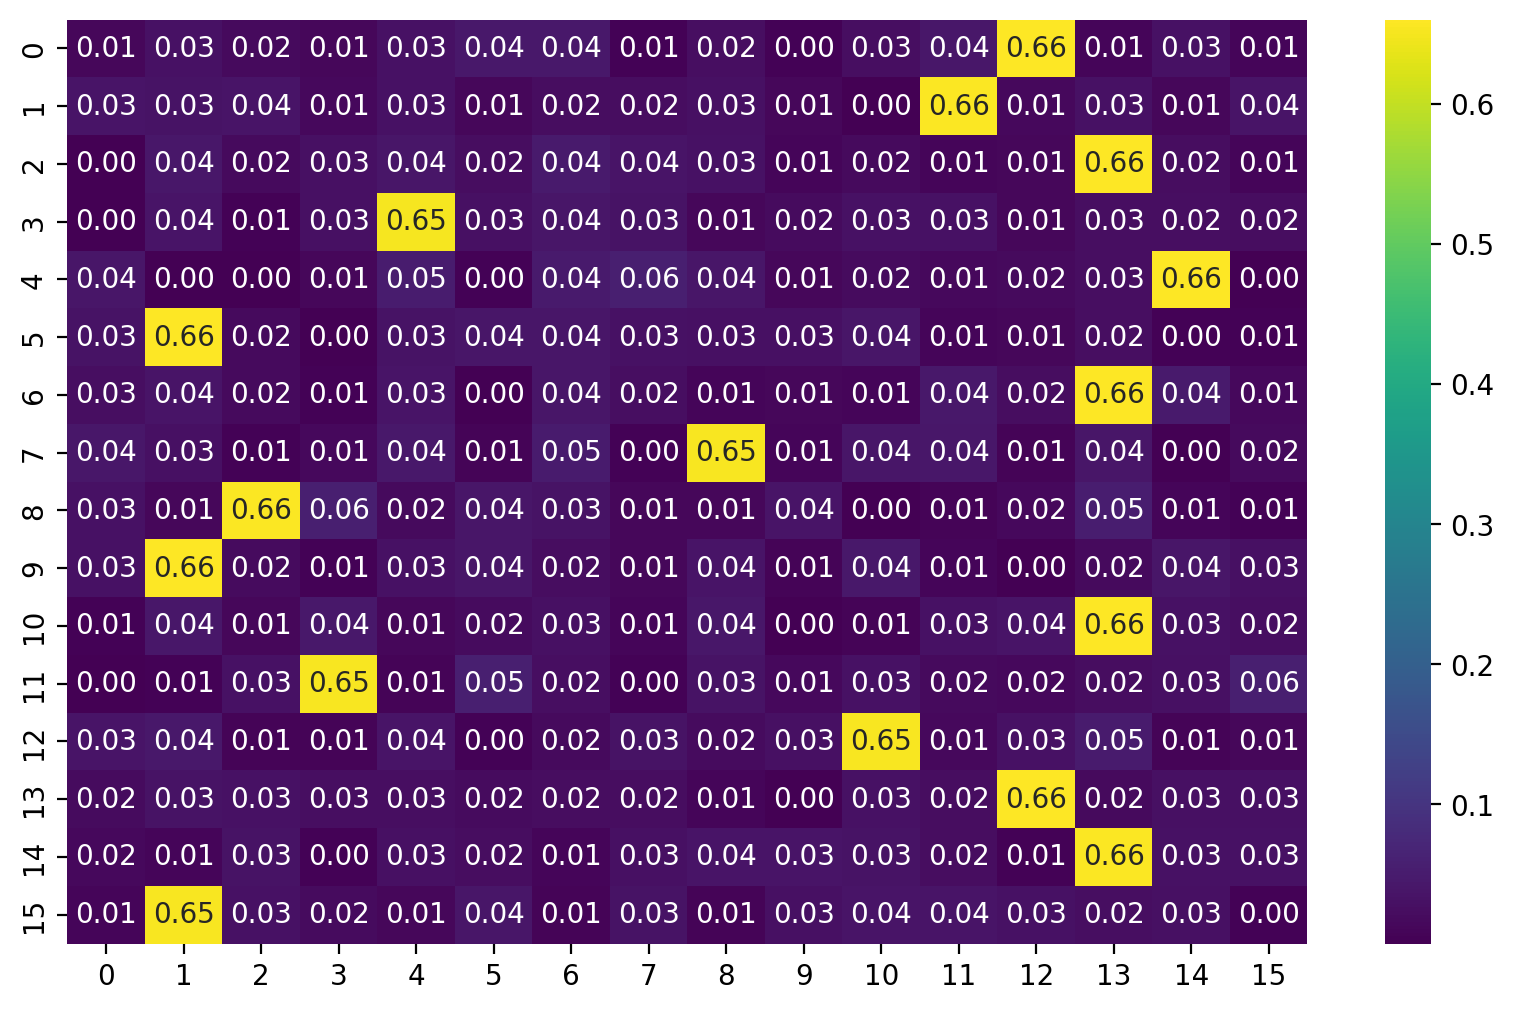

In [94]:
# Visualizing transition rules

for token in VOCABULARY:
    print(f'Transition rules for token {token}: {[round(x, 3) for x in TRANSITION_RULES[token]]}')


plt.figure(figsize=(10,6))
sns.heatmap(pd.DataFrame(TRANSITION_RULES).T, cmap='viridis', annot=True, fmt=".2f")

## Training the model

In [23]:
TRAIN_MODEL = False
EPOCHS = 10

def train_loop(model, optimizer, dataloader, device=DEVICE):
    model.train()
    total_loss = 0
    
    # the dataloader is expected to be an iterator generated by torch.utils.data.DataLoader
    for batch in dataloader:
        
        X, y = batch
        X = X.to(device)
        y = y.to(device)
        logits, loss = model(X, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        total_loss += loss.detach().item()
        
    return total_loss / len(dataloader)

def validation_loop(model, dataloader, eval_mode=True, device=DEVICE):
    
    if eval_mode:
        model.eval()
    else:
        pass

    total_loss = 0
    
    with torch.no_grad():
        
        for batch in dataloader:
            X, y = batch
            X = X.to(device)
            y = y.to(device)
            logits, loss = model(X, y)
            total_loss += loss.detach().item()
        
    return total_loss / len(dataloader)

parameters_dict = {'context_size': CONTEXT_SIZE,
                     'vocab_size': len(VOCABULARY),
                     'n_layer': NUMBER_LAYERS,
                     'n_head': NUMBER_HEADS,
                     'd_model': D_MODEL,
                     'dropout': DROPOUT,
                     'd_ff': D_FF,
                     'activation': ACTIVATION,
                     'standard_positional_encoding': USE_STANDARD_POSITIONAL_ENCODING,
                     'tie_weights': TIE_WEIGHTS_OUTPUT}


megatron = Autobot(AutobotConfig(**parameters_dict))
megatron = megatron.to(DEVICE)

optimizer = torch.optim.Adam(megatron.parameters(), lr=LEARNING_RATE, betas=(BETA_1, BETA_2), eps=EPS)

if TRAIN_MODEL:

    with open(f'models_v2/parameters_VERSION{VERSION}_experiment_{EXPERIMENT}.pt', 'wb') as f:
        pickle.dump(parameters_dict, f)

    train_losses = []
    validation_losses = []

    for _ in range(EPOCHS):
        print(f'Epoch {_+1}/{EPOCHS}')
        train_loss = train_loop(megatron, optimizer, train_dataloader)
        val_loss = validation_loop(megatron, val_dataloader)
        train_losses.append(train_loss)
        validation_losses.append(val_loss)


    df_history = pd.DataFrame({'train_loss': train_losses, 'validation_loss': validation_losses})
    df_history.to_csv('models_v2/history_VERSION{}_experiment_{}.csv'.format(VERSION, EXPERIMENT), index=False)
      
    torch.save(megatron.state_dict(), 'models_v2/model_VERSION{}_experiment_{}.pt'.format(VERSION, EXPERIMENT))

else:
    with open(f'models_v2/parameters_VERSION{VERSION}_experiment_{EXPERIMENT}.pt', 'rb') as f:
        parameters_dict = pickle.load(f)

    megatron = Autobot(AutobotConfig(**parameters_dict))
    megatron.load_state_dict(torch.load('models_v2/model_VERSION{}_experiment_{}.pt'.format(VERSION, EXPERIMENT)))
    df_history = pd.read_csv('models_v2/history_VERSION{}_experiment_{}.csv'.format(VERSION, EXPERIMENT))

number of parameters: 0.07M
number of parameters: 0.07M


## Assessing performance

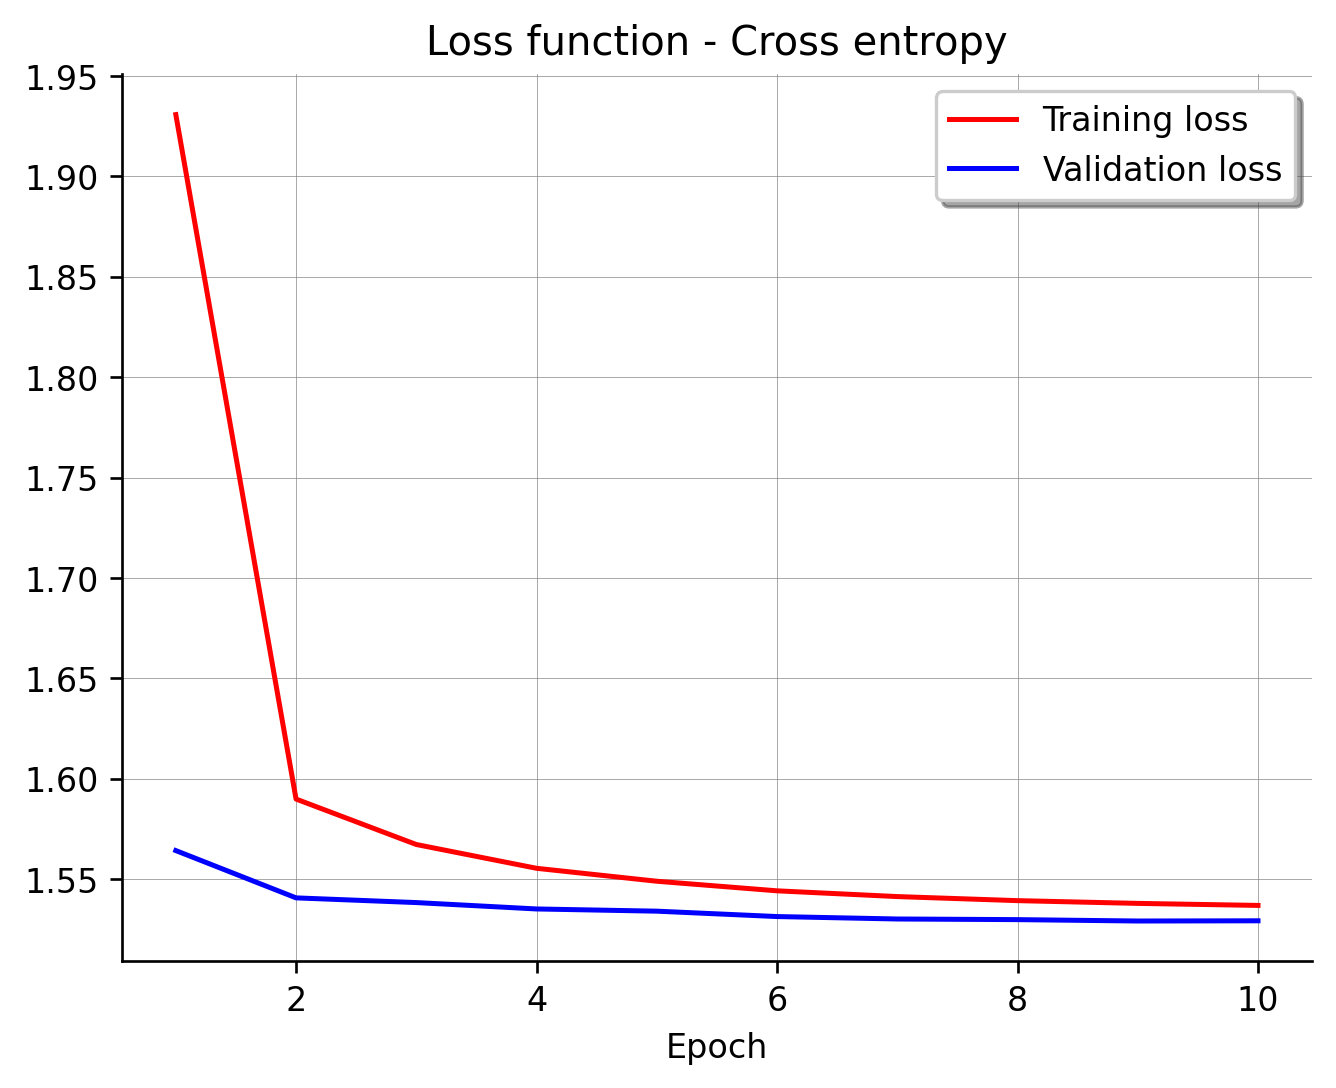

In [27]:
fig, ax = plt.subplots(dpi=120)

train_loss_list = df_history["train_loss"].values
val_loss_list = df_history["validation_loss"].values

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title("Loss function - Cross entropy")
ax.plot(range(1, len(df_history) + 1), train_loss_list, color='red', label='Training loss')
ax.plot(range(1, len(df_history) + 1), val_loss_list, color='blue', label='Validation loss')
ax.set_xlabel('Epoch')
ax.grid(lw=0.2, color='gray');
ax.legend(fancybox=True, shadow=True);
ax.grid(lw=0.2, color='gray');

In [97]:
# Examples of individual predictions

n = np.random.choice(len(test_data))

X, y_true = test_data[n]

X = torch.tensor(X.reshape(1, -1), dtype=torch.long)
y_true = torch.tensor(y_true.reshape(1, -1), dtype=torch.long)
X, y_true = X.to(DEVICE), y_true.to(DEVICE)

y_pred = megatron.generate(X, max_new_tokens=1)

print(f'Input sequence:     {"".join(["{:>3}".format(num) for num in X.cpu().numpy().flatten()])}')
print(f'True next token:      {"".join(["{:>3}".format(num) for num in y_true.cpu().numpy().flatten()][-1])}')
print(f'Predicted next token: {"".join(["{:>3}".format(num) for num in y_pred.cpu().numpy().flatten()][-1])}')


Input sequence:      13 12 10 10  3  4 14 14 13  1 11  3  3  4 14 13 12  1 11  3  3  4  0  7  8  2  4 14 15  1 11  3  6 13 13 12 10 13 12 10 13 12 10 13 12 10  8  0 12 10 13  7  8  8  2 13 12 10 13 12 10 13 12 13
True next token:        5
Predicted next token:  12


In [98]:
PRINT_FROM_REPORT = False

def last_token_acc(model, dataloader):
    
    model.eval()
    correct = 0
    total = 0
    
    
    with torch.no_grad():
        
        for batch in dataloader:
            X, y = batch
            X = X.to(DEVICE)
            y = y.to(DEVICE)
            y_pred = model.generate(X, max_new_tokens=1)
            correct += (y_pred[:,-1] == y[:,-1]).sum().item()
            total += y.shape[0]
    
    return correct / total


def entropy(transition_rules, vocab):
    
    entropies = []
    for token in vocab:
        probs = transition_rules[token]
        entropies.append(-sum([p*math.log2(p) for p in probs if p > 0])) 
    
    return np.mean(entropies)

def get_ideal_score(test_samples, transition_rules):
    
    ideal_scores = []
    for X, y in test_samples:
        next_token = transition_rules[y[-2].item()].index(max(transition_rules[y[-2].item()]))
        if next_token == y[-1].item():
            ideal_scores.append(1)
        else:
            ideal_scores.append(0)

    return sum(ideal_scores) / len(ideal_scores)



if PRINT_FROM_REPORT:

    with open('models_v2/performance_report_version{}_experiment_{}.pkl'.format(VERSION, EXPERIMENT), 'r') as f:
        performance_report = pickle.load(f)
    print(performance_report)

else:
    
    last_token_acc_train = last_token_acc(megatron, train_dataloader)
    last_token_acc_val = last_token_acc(megatron, val_dataloader)
    last_token_acc_test = last_token_acc(megatron, test_dataloader)


    print('Matrix entropy:', entropy(TRANSITION_RULES, VOCABULARY))
    print(f'Last token accuracy on training set: {last_token_acc_train:.2f}. Ideal score: {get_ideal_score(train_data, TRANSITION_RULES):.2f}')
    print(f'Last token accuracy on validation set: {last_token_acc_val:.2f}. Ideal score: {get_ideal_score(val_data, TRANSITION_RULES):.2f}')
    print(f'Last token accuracy on test set: {last_token_acc_test:.2f}. Ideal score: {get_ideal_score(test_data, TRANSITION_RULES):.2f}')


    ###### Additional evaluations - test set

    test_scores = [last_token_acc_test]
    for _ in range(5):
        test_sequences = generate_sequences(VOCABULARY, SEQUENCE_LENGTH, int(NUM_SEQUENCES*TEST_FRACTION), TRANSITION_RULES)
        test_dataloader_temp = DataLoader(shift_and_append(test_sequences), batch_size=BATCH_SIZE, drop_last=True)
        test_scores.append(last_token_acc(megatron, test_dataloader_temp))

    min_test_score = min(test_scores)
    max_test_score = max(test_scores)
    mean_test_score = np.mean(test_scores)

    print(f'Minimum last token accuracy on test set: {min_test_score:.2f}')
    print(f'Maximum last token accuracy on test set: {max_test_score:.2f}')
    print(f'Mean last token accuracy on test set: {mean_test_score:.2f}')

    performance_report = dict()

    performance_report['VERSION'] = VERSION
    performance_report['experiment'] = EXPERIMENT
    performance_report['train_last_token_accuracy'] = last_token_acc_train
    performance_report['val_last_token_accuracy'] = last_token_acc_val
    performance_report['test_last_token_accuracy_mean'] = mean_test_score
    performance_report['test_last_token_accuracy_min'] = min_test_score
    performance_report['test_last_token_accuracy_max'] = max_test_score
    performance_report['epochs'] = EPOCHS
    performance_report['matrix_entropy'] = entropy(TRANSITION_RULES, VOCABULARY)

    with open('models_v2/performance_report_version{}_experiment_{}.pkl'.format(VERSION, EXPERIMENT), 'wb') as f:
        pickle.dump(performance_report, f)

Matrix entropy: 2.1758126348942834
Last token accuracy on training set: 0.66. Ideal score: 0.66
Last token accuracy on validation set: 0.66. Ideal score: 0.66
Last token accuracy on test set: 0.67. Ideal score: 0.67
Minimum last token accuracy on test set: 0.65
Maximum last token accuracy on test set: 0.67
Mean last token accuracy on test set: 0.66


In [99]:
# Final checkpoint
print(f'Last experiment executed: {EXPERIMENT}. Current version: {VERSION}')

Last experiment executed: 6. Current version: 2.1


## Analyzing the results

In [4]:
performance_report

{'VERSION': '1',
 'experiment': '6',
 'train_last_token_accuracy': 0.654,
 'val_last_token_accuracy': 0.650125,
 'test_last_token_accuracy_mean': 0.6537916666666667,
 'test_last_token_accuracy_min': 0.64475,
 'test_last_token_accuracy_max': 0.65975,
 'epochs': 10,
 'matrix_entropy': 1.819099454835401}

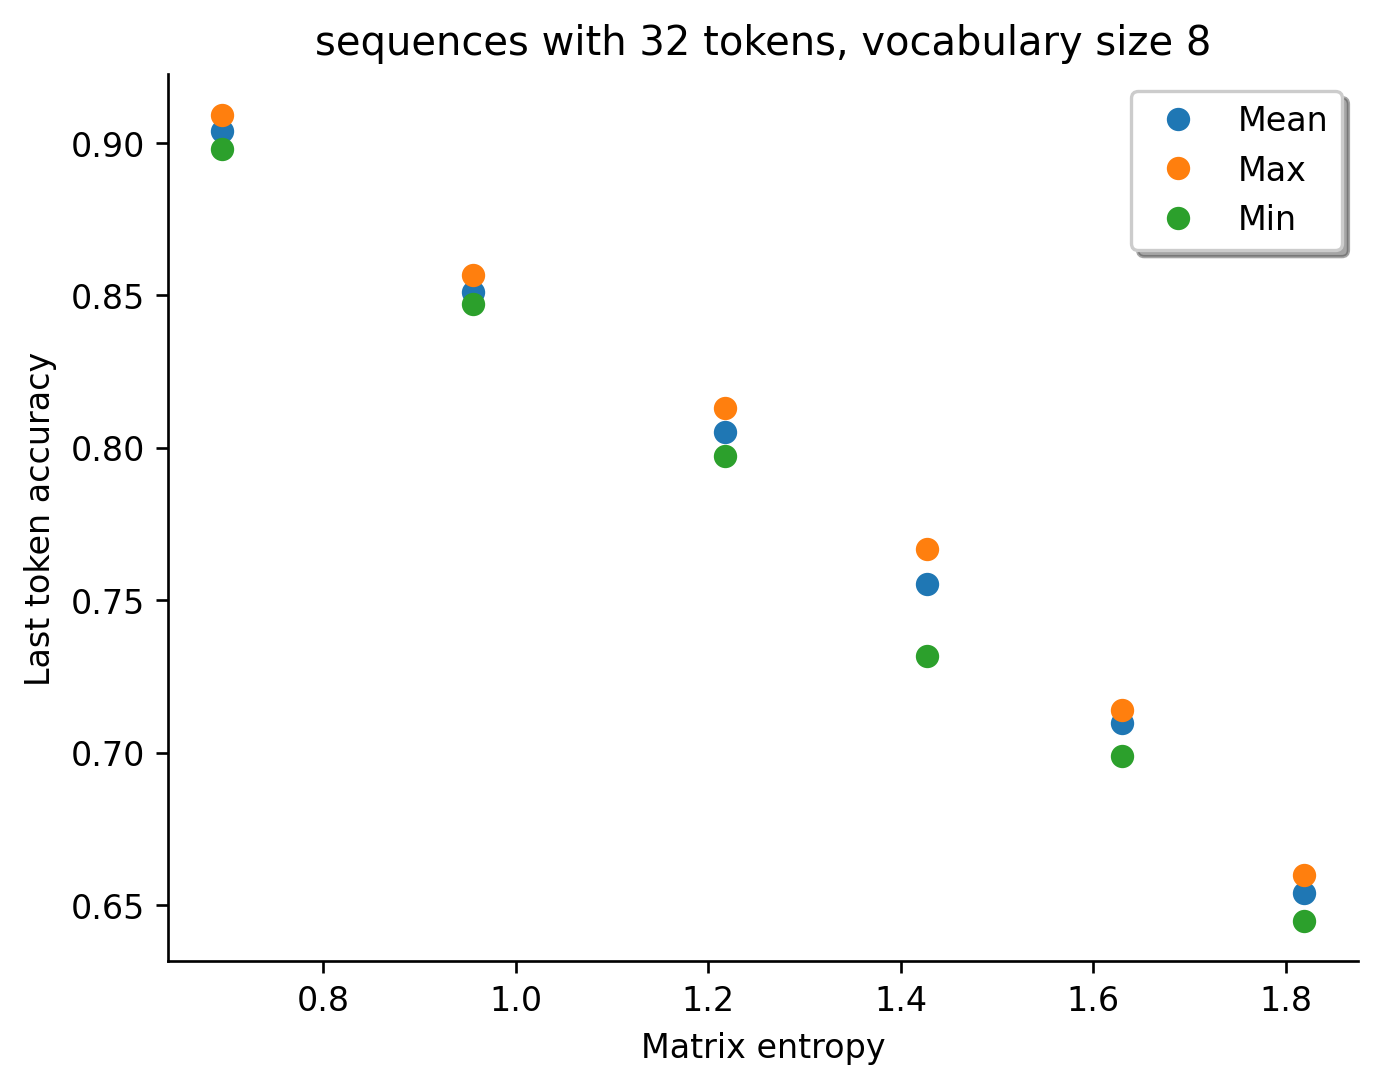

In [8]:
version = '1'
entropy_list = []
last_token_acc_test_list = []
max_list = []
min_list = []
ideal_score_list = []
for experiment in ['1', '2', '3', '4', '5', '6']:
    with open('models_v2/performance_report_version{}_experiment_{}.pkl'.format(version, experiment), 'rb') as f:
        performance_report = pickle.load(f)
    entropy_list.append(performance_report['matrix_entropy'])
    last_token_acc_test_list.append(performance_report['test_last_token_accuracy_mean'])
    max_list.append(performance_report['test_last_token_accuracy_max'])
    min_list.append(performance_report['test_last_token_accuracy_min'])
    ideal_score_list.append(performance_report['test_last_token_accuracy_max'])


fig, ax = plt.subplots(dpi=120)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title("sequences with 32 tokens, vocabulary size 8")

ax.plot(entropy_list, last_token_acc_test_list, 'o', label='Mean')
ax.plot(entropy_list, max_list, 'o', label='Max')
ax.plot(entropy_list, min_list, 'o', label='Min')

ax.set_xlabel('Matrix entropy')
ax.set_ylabel('Last token accuracy')

ax.legend(fancybox=True, shadow=True)


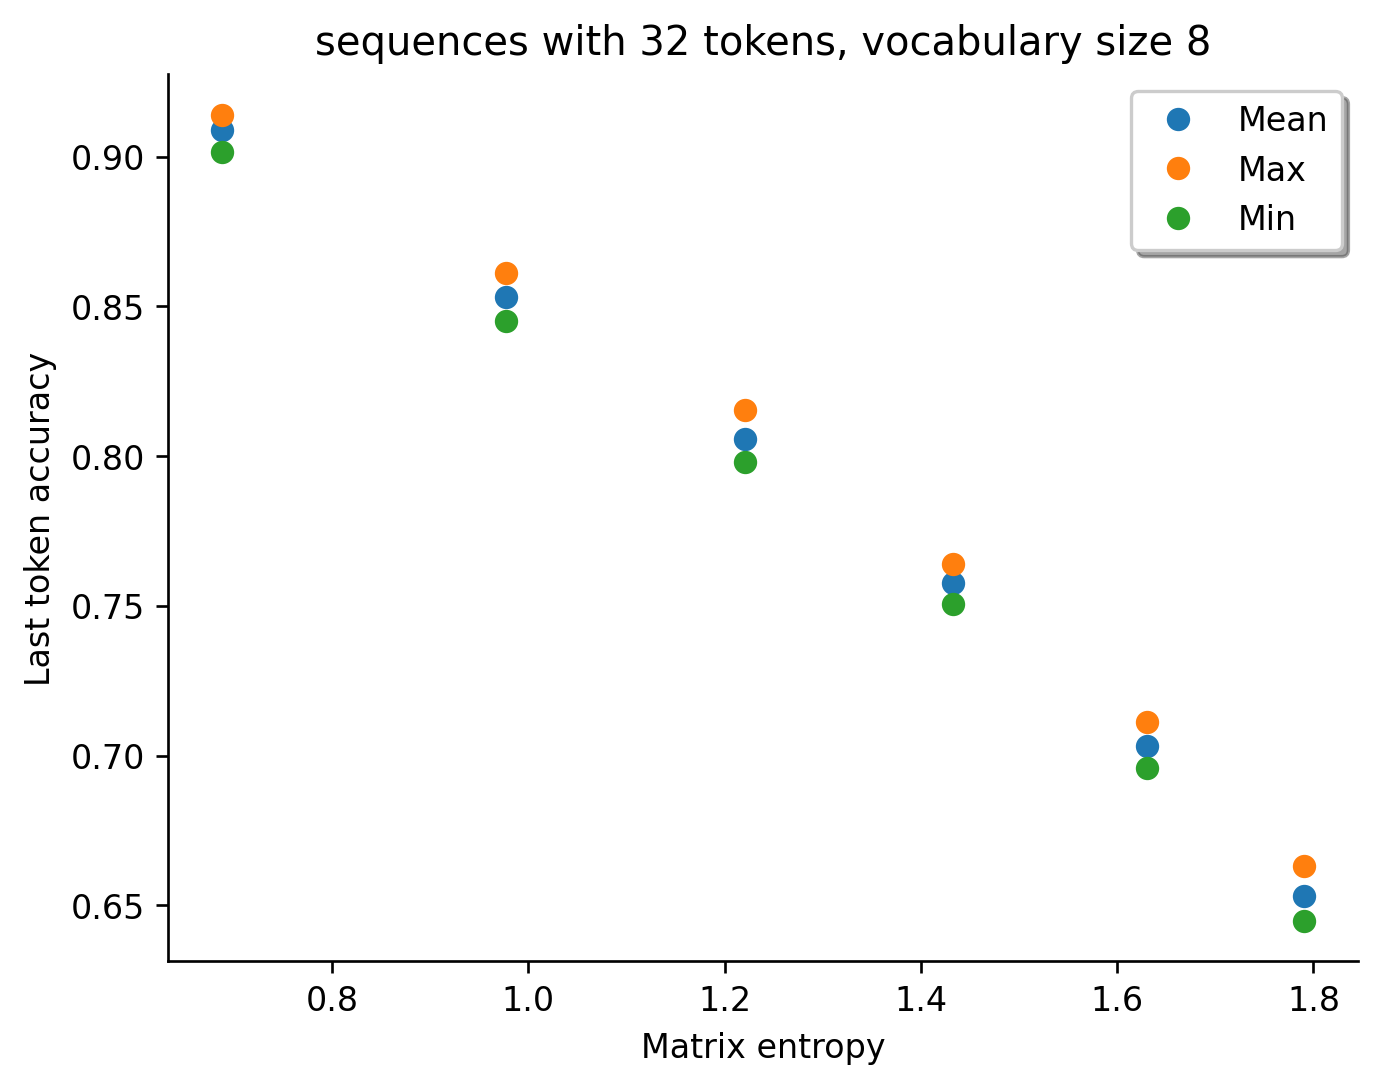

In [9]:
version = '1.1'
entropy_list = []
last_token_acc_test_list = []
max_list = []
min_list = []
ideal_score_list = []
for experiment in ['1', '2', '3', '4', '5', '6']:
    with open('models_v2/performance_report_version{}_experiment_{}.pkl'.format(version, experiment), 'rb') as f:
        performance_report = pickle.load(f)
    entropy_list.append(performance_report['matrix_entropy'])
    last_token_acc_test_list.append(performance_report['test_last_token_accuracy_mean'])
    max_list.append(performance_report['test_last_token_accuracy_max'])
    min_list.append(performance_report['test_last_token_accuracy_min'])
    ideal_score_list.append(performance_report['test_last_token_accuracy_max'])


fig, ax = plt.subplots(dpi=120)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title("sequences with 32 tokens, vocabulary size 8")

ax.plot(entropy_list, last_token_acc_test_list, 'o', label='Mean')
ax.plot(entropy_list, max_list, 'o', label='Max')
ax.plot(entropy_list, min_list, 'o', label='Min')

ax.set_xlabel('Matrix entropy')
ax.set_ylabel('Last token accuracy')

ax.legend(fancybox=True, shadow=True)


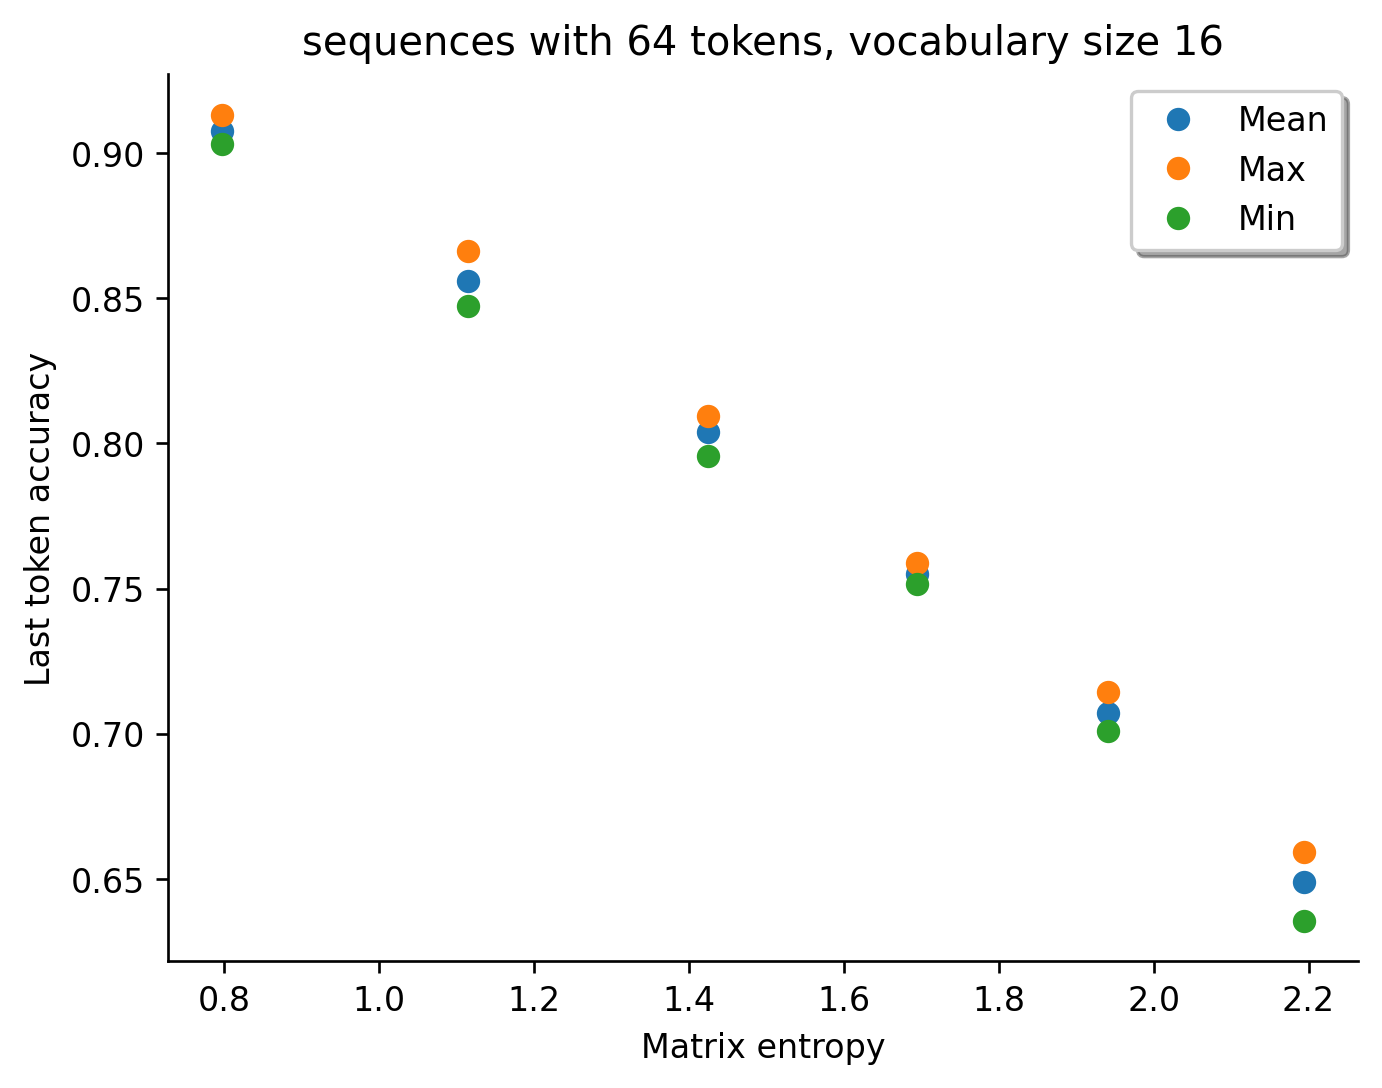

In [10]:
version = '2'
entropy_list = []
last_token_acc_test_list = []
max_list = []
min_list = []
ideal_score_list = []
for experiment in ['1', '2', '3', '4', '5', '6']:
    with open('models_v2/performance_report_version{}_experiment_{}.pkl'.format(version, experiment), 'rb') as f:
        performance_report = pickle.load(f)
    entropy_list.append(performance_report['matrix_entropy'])
    last_token_acc_test_list.append(performance_report['test_last_token_accuracy_mean'])
    max_list.append(performance_report['test_last_token_accuracy_max'])
    min_list.append(performance_report['test_last_token_accuracy_min'])
    ideal_score_list.append(performance_report['test_last_token_accuracy_max'])


fig, ax = plt.subplots(dpi=120)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title("sequences with 64 tokens, vocabulary size 16")

ax.plot(entropy_list, last_token_acc_test_list, 'o', label='Mean')
ax.plot(entropy_list, max_list, 'o', label='Max')
ax.plot(entropy_list, min_list, 'o', label='Min')

ax.set_xlabel('Matrix entropy')
ax.set_ylabel('Last token accuracy')

ax.legend(fancybox=True, shadow=True)


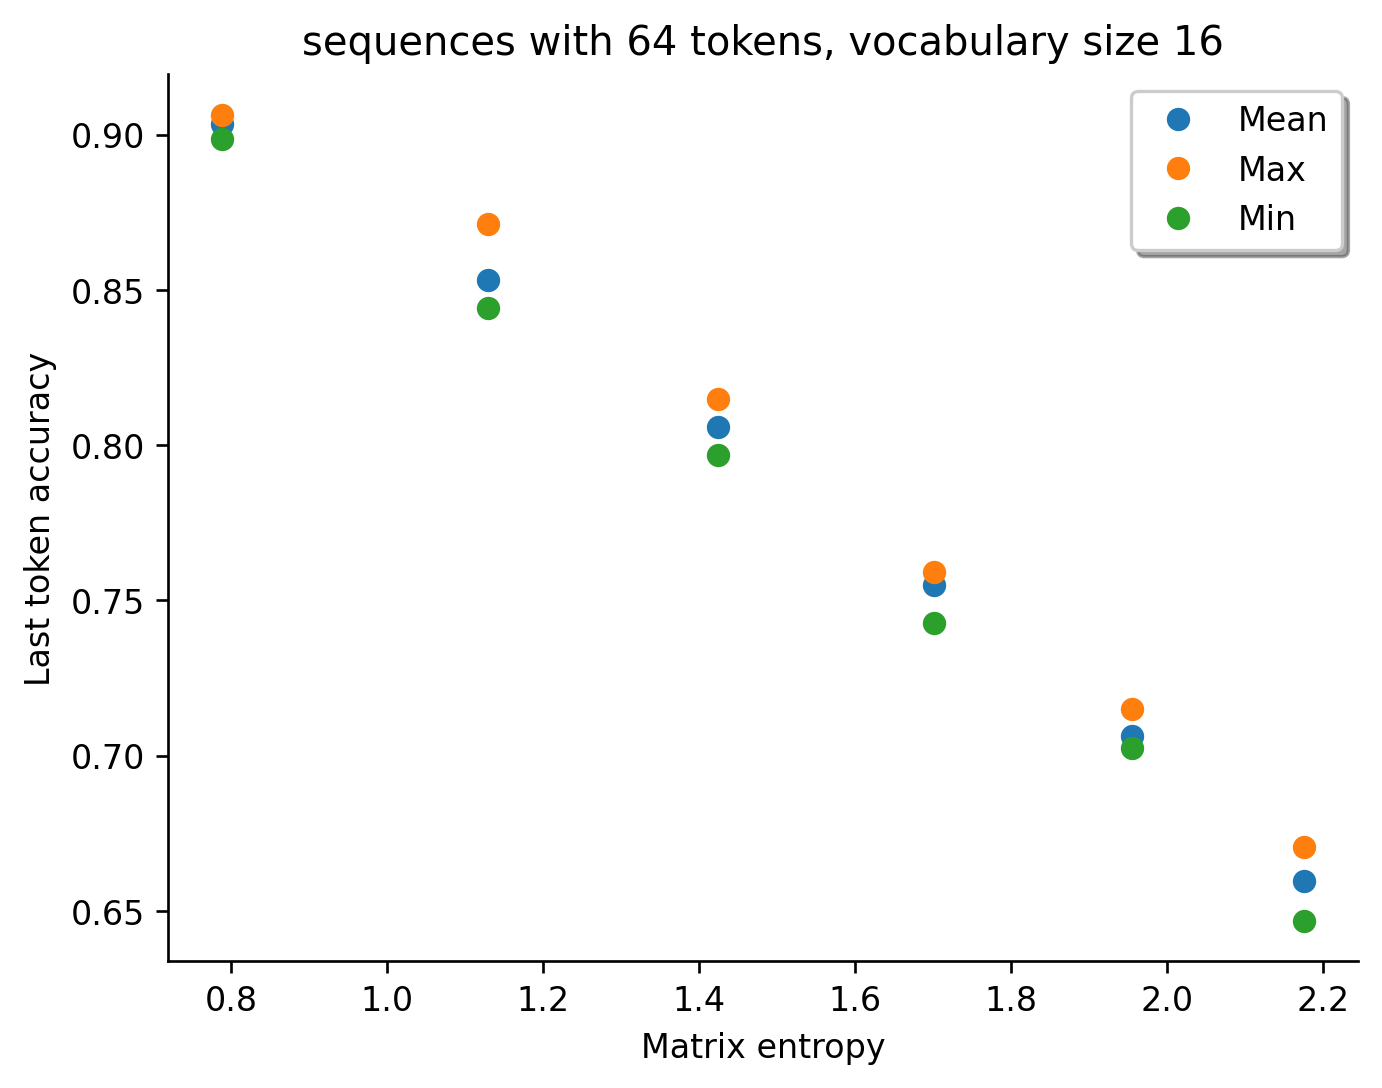

In [12]:
version = '2.1'
entropy_list = []
last_token_acc_test_list = []
max_list = []
min_list = []
ideal_score_list = []
for experiment in ['1', '2', '3', '4', '5', '6']:
    with open('models_v2/performance_report_version{}_experiment_{}.pkl'.format(version, experiment), 'rb') as f:
        performance_report = pickle.load(f)
    entropy_list.append(performance_report['matrix_entropy'])
    last_token_acc_test_list.append(performance_report['test_last_token_accuracy_mean'])
    max_list.append(performance_report['test_last_token_accuracy_max'])
    min_list.append(performance_report['test_last_token_accuracy_min'])
    ideal_score_list.append(performance_report['test_last_token_accuracy_max'])


fig, ax = plt.subplots(dpi=120)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title("sequences with 64 tokens, vocabulary size 16")

ax.plot(entropy_list, last_token_acc_test_list, 'o', label='Mean')
ax.plot(entropy_list, max_list, 'o', label='Max')
ax.plot(entropy_list, min_list, 'o', label='Min')

ax.set_xlabel('Matrix entropy')
ax.set_ylabel('Last token accuracy')

ax.legend(fancybox=True, shadow=True)
